# 📊 Salesforce MQL Sourcing Analysis

This project explores how marketing-qualified leads (MQLs) are sourced via Salesforce campaigns. It includes:

- A connection to Salesforce via `pandaforce`
- Basic data cleaning and normalization
- Exploration of campaign-level attribution

👉 Intended as a proof of concept for client-side automation and exploration.

> **Note:** All sensitive data has been anonymized or removed.

In [ ]:
from pandaforce import pandaforce as pf
import pandas as pd
import csv

### 🔐 Connect to Salesforce

This cell logs into the Salesforce API using the `pandaforce` library (a Python wrapper around Salesforce's REST API.)

- The user is prompted for their **Salesforce password**.
- The username, organization ID, and security token should be manually added or inputted securely.
- Consider storing secrets in environment variables or a `.env` file for better security.

In [ ]:
# get credentials
pw = input("Enter your Salesforce password: ")

# Authenticate to Salesforce
sf=pf.login(username='YOUR_USERNAME_HERE', 
            password=pw, 
            orgid='YOUR_ORG_ID_HERE',
            securitytoken='INSERT_YOUR_SECURITY_TOKEN_HERE') # TODO: Secure this value later.

Next, I wanted to see: is my client already tracking Lead Status changes to "MQL" in the lead history, which Salesforce automatically tracks?

We can use Pandaforce to turn a SOQL query -- "get me all lead status changes from `LeadHistory`" -- into a dataframe easily.

In [298]:
leadStatusHist=sf.getdf("SELECT LeadId, Field, OldValue, NewValue, CreatedDate FROM LeadHistory WHERE Field='Status'")

In [299]:
# First, we group the statuses and counts.
# Then we rename the columns so they make a little more sense.
statusCounts=leadStatusHist.groupby(by="NewValue", as_index=False)['LeadId'].count()\
    .rename(columns={"NewValue": "Lead Status", "LeadId": "# leads"})
statusCounts # let's see what it shows us:

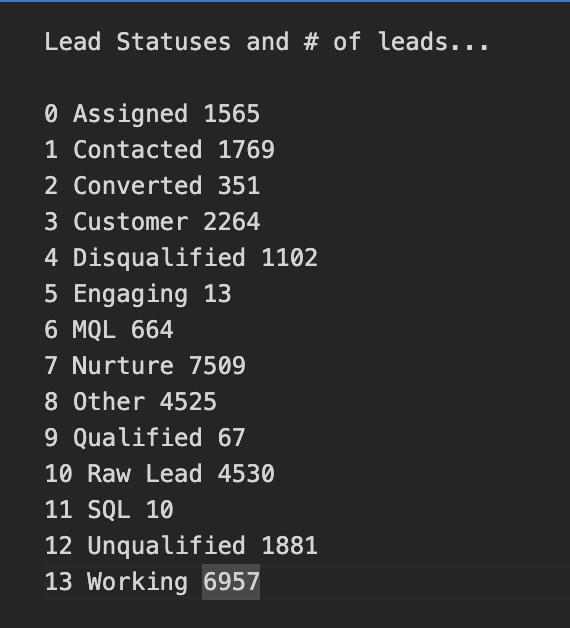

Since this is a client using the measurable lead model, they have some newer data where an MQL is essentially marked as Assigned to a rep (at the top), but also some older historical records where their Status used to be marked as ‘MQL.’ We actually cleaned all this data up as part of our client engagement, but since this is a lead history report, we still have the history of older MQL value changes. No problem.

What we'll do:
We need to filter down that `leadHistory` to just those values. We also want to make sure that we only get the first time that this lead switched to an MQL value , so we also want to deduplicate the field history by LeadId, and keep only the first row by CreatedDate. (Since we’re dealing with Lead history, CreatedDate is the date the record MQLed, not the date the lead was created!)

In [ ]:
mqlVals=['Assigned','MQL']
firstMQL=leadStatusHist[leadStatusHist['NewValue'].isin(mqlVals)]\
    .sort_values(by=['CreatedDate'])\
    .drop_duplicates(subset=['LeadId'], keep='first')\
    .rename(columns={"CreatedDate": "LeadUpdatedDate"})\
    .reset_index(drop=True) # this will make things tidier later
firstMQL.head() #Check and make sure things look as expected

### Example Output

This spits out some lead IDs, the field, the old and new statuses, and the date the lead was first updated to that date. We now have that stored as firstMQL. This is a sample of what the cleaned MQL dataset looks like:

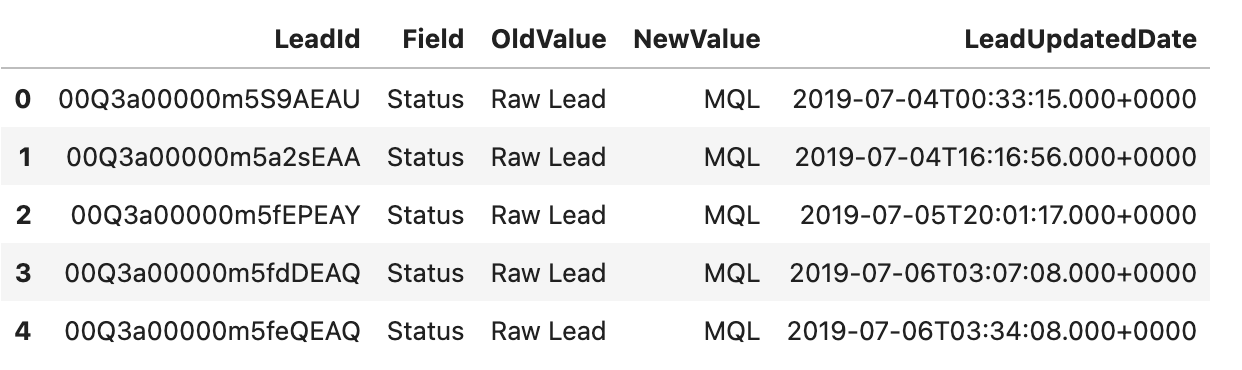

Great! Now how do we compare that to the campaign responses and figure out which one caused this MQL?

First, let’s get all campaign members from Salesforce. It’s less expensive to filter them in Pandas now that we have a list of LeadIds that we want to filter down by.

In [302]:
# First, get list of lead IDs
leads=firstMQL['LeadId'].tolist() 

# Then, pull all campaign  members from Salesforce to generate our campaign source data
campMembs=sf.getdf("SELECT id, LeadId, CampaignId, FirstRespondedDate FROM CampaignMember WHERE HasResponded=true")

# Now filter down to only campaign memberships for our leads we're working with
campMembs=campMembs[campMembs['LeadId'].isin(leads)].reset_index()

We need to cast our `LeadUpdatedDate` and `FirstRespondedDate` to datetime formats for us to be able to perform operations on them. I should have done this when I first brought in the dataframe, but I’m telling a story, OK? 😂

Fortunately, I know from experience that Python is mercifully, gloriously good at reading Salesforce date/time outputs.

I also know thatLeadUpdatedDate got a time zone when we casted it to datetime, probably because it had both a date and a time, but `FirstRespondedDate` didn’t, since it was actually just a date.

We’ll need to be careful here since the `FirstRespondeddDate` has no time on it. Someone could have responded to a campaign anytime in a 24-hour period. But I think it’s safe to say that a 24-hour period is enough time to make sure that any marketing attribution comes in. We’re going to have to look at absolute value differences between the MQL date and the `FirstRespondedDate` since theoretically most MQL dates will be “after” the `FirstRespondedDate`, if, say, I MQLed at 11AM on Monday but the `FirstRespondedDate` has Monday at midnight.

In [316]:
#  Get datetime formats set correctly so we can calculate the time delta between them
campMembs['FirstRespondedDate_UTC']=pd.to_datetime(campMembs['FirstRespondedDate'])\
    .dt.tz_localize('UTC')

firstMQL['LeadUpdatedDate_UTC']=pd.to_datetime(firstMQL['LeadUpdatedDate'])

Now that our data is set up, onto the heart of the calculation, in which we loop through our leads, find out if there are any campaign responses associated with them, and get that data into output collections. I commented this section pretty heavily, so hopefully it makes sense.

In [317]:
results={} # create a dict which will store the campaign members that match the lead
leadswithnoCMs=[] # create a list to store leads with no matching campaign members

for i in range(len(firstMQL)): # Looping through the first MQL table...
    thislead=firstMQL.iloc[i] # set 'thislead' to be the row we're working with
    mqlDate_UTC=thislead['LeadUpdatedDate_UTC'] # set MQL date with UTC timezone for calculation
    mqlDate=thislead['LeadUpdatedDate'] # I'm going to keep a regular date variable for the output though
    thisleadId=thislead['LeadId'] 
    
    # Now, filter down the CM dataframe to only this lead we're working with right now
    thisLeadCMs=campMembs[campMembs['LeadId']==thisleadId] #filter CMs to only this lead
    
    if not thisLeadCMs.empty: #if there are any campaign members for this lead...
        for c in range(len(thisLeadCMs)): #loop through them...
            thisCM=thisLeadCMs.iloc[c] # ...selecting one row at a time
            timeDiff=abs(thisCM['FirstRespondedDate_UTC']-mqlDate_UTC) # get the delta between the two UTC dates
            
            # Now add the 
            if timeDiff.days<1: # If they are within 24h of each other...
                values={'CampaignId': thisCM['CampaignId'],  # add the campaign id...
                        'CampaignFirstRespondedDate':thisCM['FirstRespondedDate'], # and the campaign response date
                        'LeadMQLDate': mqlDate  # and the MQL date (in its original format)
                       }
                results.update({thisleadId:values}) #  Now add these data to our results dictionary for later.
                
    
    else: # but if there are no campaign members for this lead...
        leadswithnoCMs.append(thisleadId) # ...we'll add those leadIDs to a separate list for later.

I definitely checked out the leadswithnoCMs output list to see how many MQLs didn’t even have a campaign source within 24 hours, and also confirmed that the results dictionary handled my leads with one or more campaign sources.

Making our calculations readable

From here, what’s left?

* Get the results dictionary of leads with campaign sources into a dataframe format looking pretty
* Summarize this table to sum up the total MQLs by campaign type and campaign name, which is what most clients want anyway
* Get the leadswithnoCMs list of leads with no campaign source also into a nice looking dataframe
* Write all this goodness to an Excel doc (or Google Sheet, etc.) for folks to pore over

OK, let’s get to it.

### 1. Get the results dictionary of leads with campaign sources into a dataframe format looking pretty

This part wasn’t so bad, but was time consuming: first, it was making a dataframe of the results, and then enriching it with more campaign and lead data.

I will admit that understanding how Pandas indexing works is still something I’m learning about, so I ended up moving around the index in a way that I’m sure is less than maximally elegant while getting the data into a dataframe.

From there it was just a lot of merging and reordering of columns to make the output data look good:

In [318]:
'''Take the results of the loop and reformat them'''

df=pd.DataFrame.from_dict(results,orient='index') #Take the campaign dictionary and make a dataframe from it
df.reset_index(level=0, inplace=True) #Reset the index so the lead ID gets its own column

# Now rename the former index col more clearly, order by responded date, and dedupe to only the first response
df=df.rename(columns={'index':'LeadId'})\
    .sort_values(by=['LeadId', 'CampaignFirstRespondedDate'])\
    .drop_duplicates(subset='LeadId', keep='first') #drop any duplicates

…at the very end below I also snuck in the extra output dataframe which was just a groupby to save the user having to make a pivot table. Therefore: 

### 2: Summarize this table to sum up the total MQLs by campaign type and campaign name

... which is what most clients want anyway -- also checked off the list. ✅

In [ ]:
'''Get lead and campaign data from Salesforce to join into this table '''

camps=sf.getdf("SELECT id, name, type FROM campaign")
leads=sf.getdf("SELECT id, name, company, title FROM lead")

# Adding prefixes makes everything way easier to read
camps=camps.add_prefix('Source_Campaign_')
leads=leads.add_prefix('Lead_')

# Now merge in the campaign and lead data into the table
campmerge=df.merge(camps,left_on='CampaignId',right_on='Source_Campaign_Id')\
    .drop(columns='Source_Campaign_Id')\
    .merge(leads,left_on='LeadId',right_on='Lead_Id')\
    .drop(columns='Lead_Id') #merge in lead data then drop the duplicate lead ID

# Reorganize the columns for legibility
cols=campmerge.columns.tolist()

def moveToFront(list, item): #Create function for reordering cols
    old_index = list.index(item) #Find old list position...
    list.insert(0,list.pop(old_index)) #...and move item to new list position
    
moveToFront(cols,'Lead_Title')
moveToFront(cols,'Lead_Company')
moveToFront(cols,'Lead_Name')
moveToFront(cols,'Source_Campaign_Type')
moveToFront(cols,'Source_Campaign_Name')

campmerge=campmerge[cols]\
    .sort_values(by=['Source_Campaign_Type','Source_Campaign_Name','Lead_Name'])\
    .reset_index(drop=True) # reset index and drop the existing index

#  Also let's add a summary table of the raw campaign data.
# This will count the unique leads
summary=campmerge.groupby(['Source_Campaign_Type','Source_Campaign_Name'], as_index=False)['LeadId'].count()\
    .rename(columns={"LeadId":"Number_of_MQLs"})

_Note: Data shown here is anonymized for privacy and confidentiality._

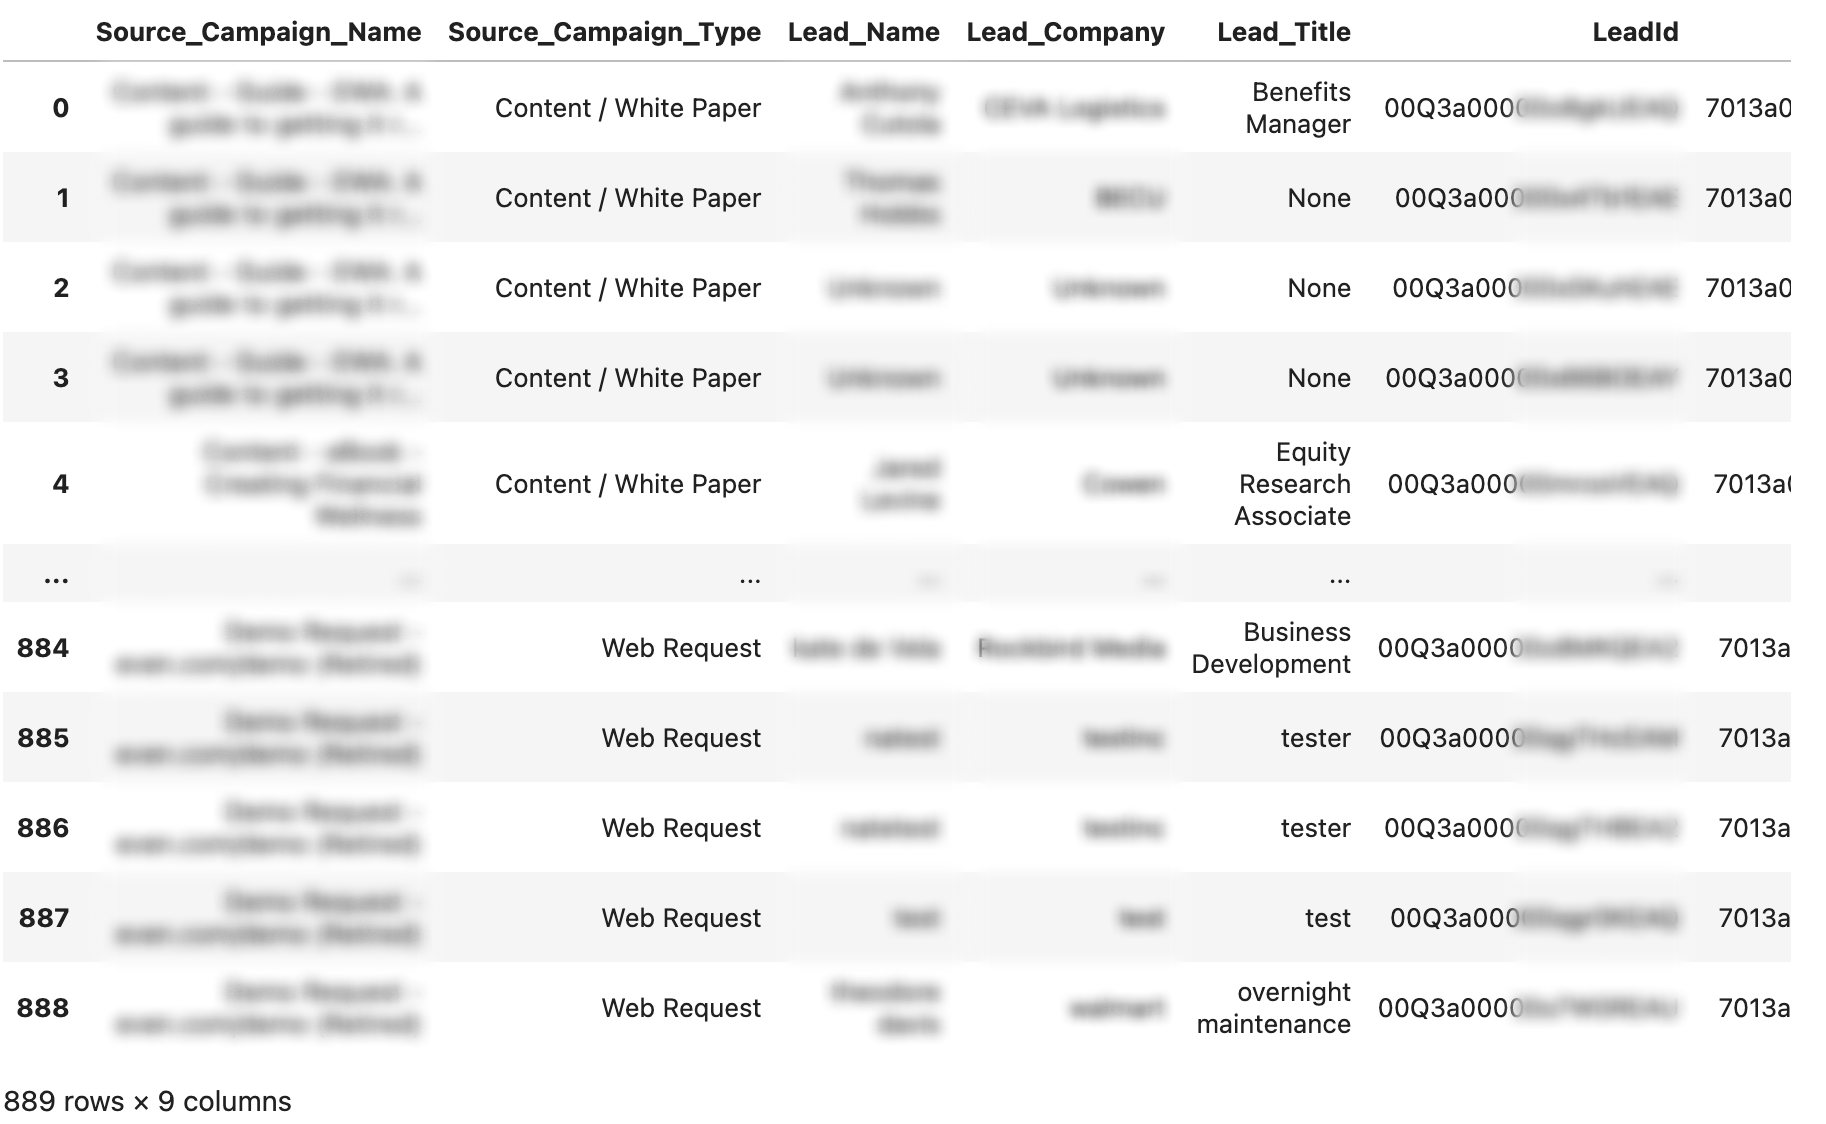

Next: 

### 3. Get the `leadswithnoCMs` list of leads with no campaign source also into a nice looking dataframe

This part wasn’t so bad either. It was a little confusing to figure out that I had to merge back in the original MQL date (LeadUpdatedDateas originally exported) rather than the UTC version that we generated for the calculation. Turns out the Excelwriter in the next step doesn’t like timezone aware datetimes, which was a head-scratcher for a minute.

In [327]:
# Now to write the leads without sources to a table
# We return to our 'leadswithnoCMs' list of Lead IDs

leadswNoSource=pd.DataFrame(leadswithnoCMs, columns=['Lead_Id'])

# Now merge with the leads DF to get other lead fields
leadswNoSource=leadswNoSource.merge(leads, left_on='Lead_Id', right_on='Lead_Id')

# We will also merge back in the MQL date
mqlDateDF=firstMQL[['LeadId','LeadUpdatedDate']]
leadswNoSource=leadswNoSource.merge(mqlDateDF,left_on='Lead_Id',right_on='LeadId')\
    .drop(columns='LeadId')\
    .rename(columns={'LeadUpdatedDate':'MQL_Date'})

Almost there! Last step!!

#### 4: Write all this goodness to an Excel doc (or Google Sheet, etc.) for folks to pore over ✅

**ExcelWriter** is a fantastic tool. I have always been too lazy to use any of its formatting tricks, but it’s nice to know it’s there.

In [330]:
'''Write everything to ExcelWriter'''

filePath='/Users/martinbourqui/Downloads/MQLSources.xlsx'

with pd.ExcelWriter(filePath) as writer:  
    leadsWithSourcesTitle=str("All leads with source campaigns")
    campmerge.to_excel(writer, sheet_name=leadsWithSourcesTitle)
    
    summaryTitle=str("Campaign source summary totals")
    summary.to_excel(writer, sheet_name=summaryTitle)
    
    leadsWNoSourceTitle=str("MQLs w no matching camp. source")
    leadswNoSource.to_excel(writer, sheet_name=leadsWNoSourceTitle) 

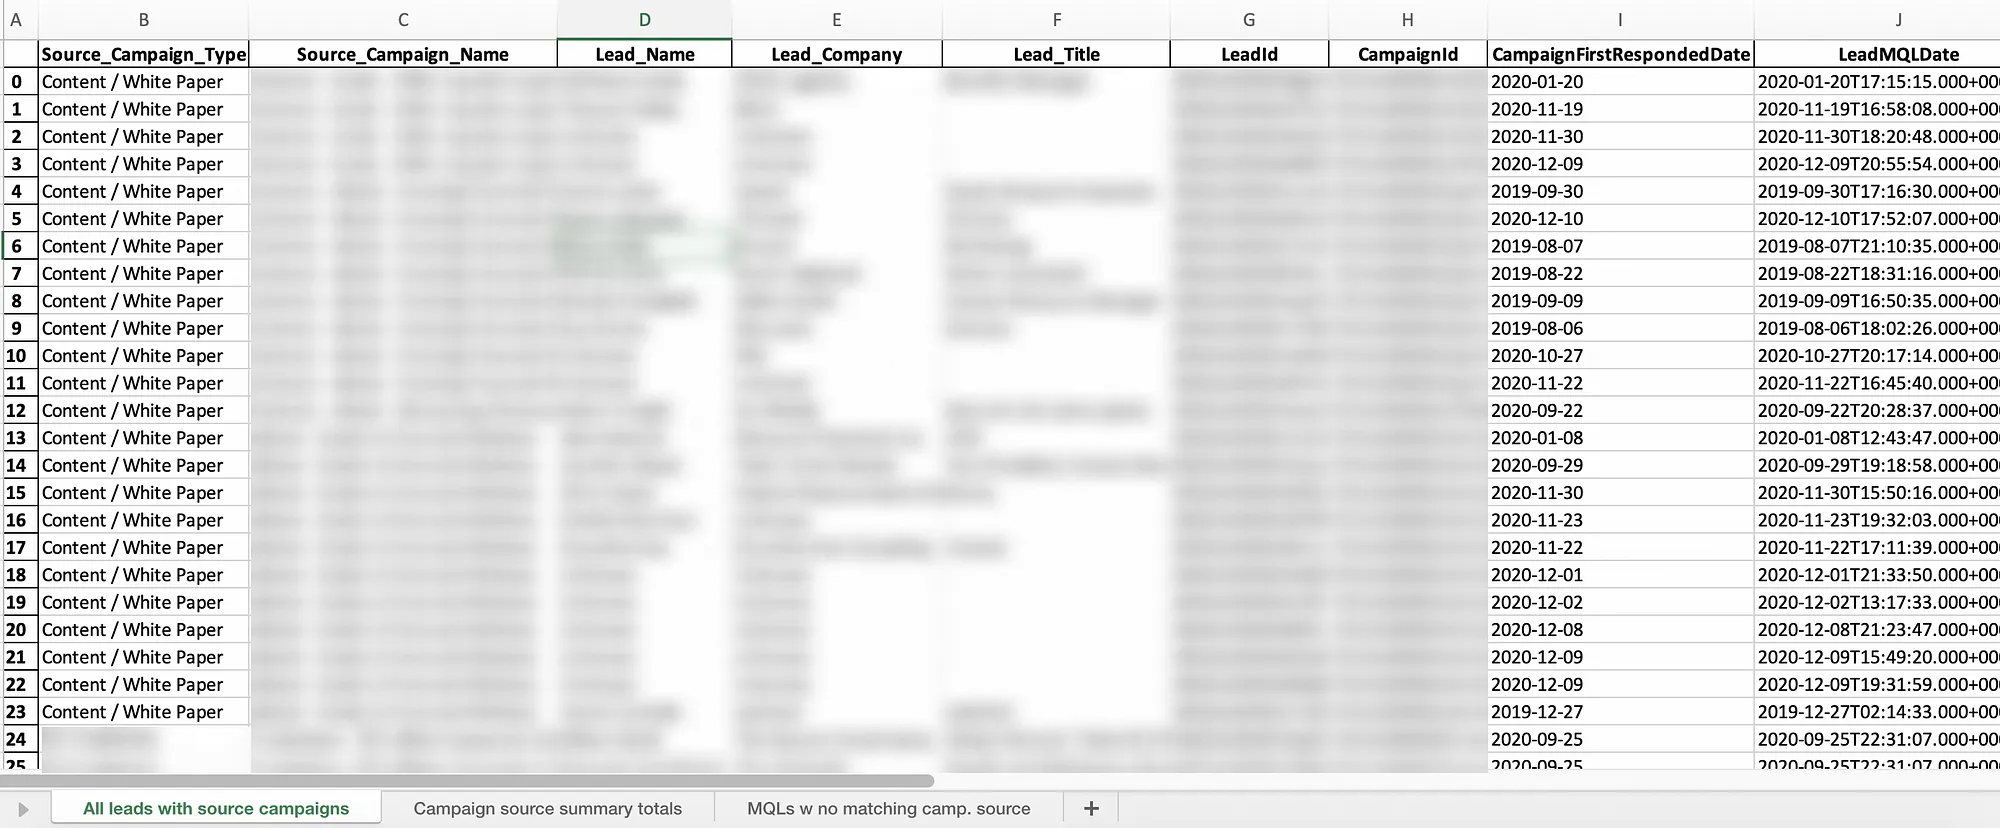

The second tab, our summary totals, gives us a total # of lead MQLs by campaign+type:

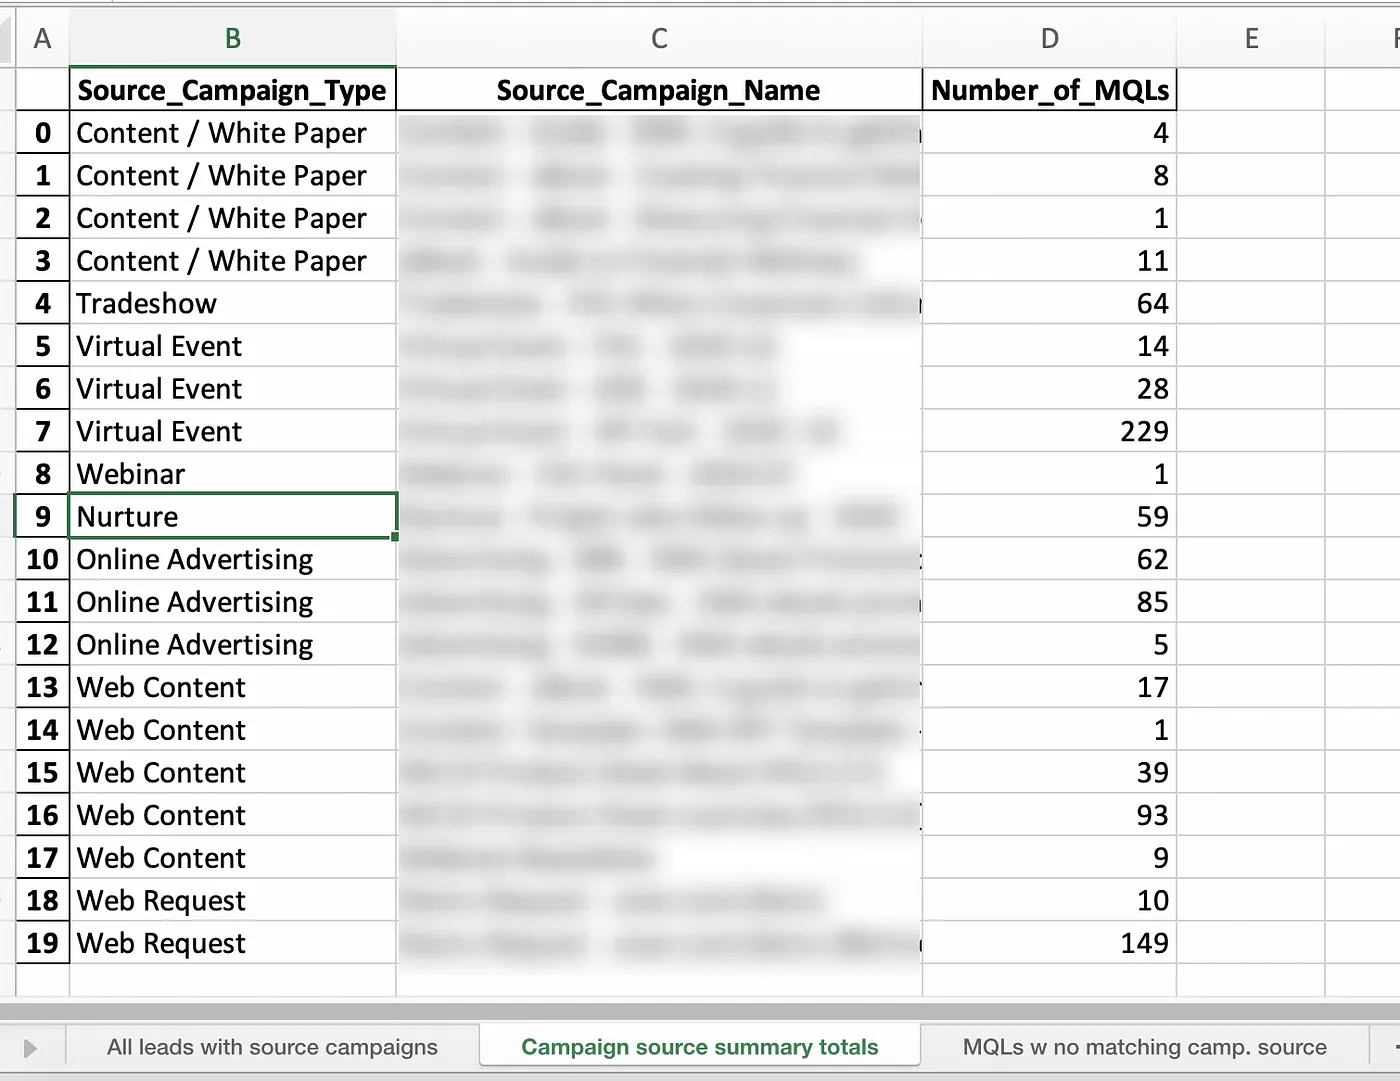

And then for reference, the final tab includes the names, emails, titles, Salesforce ID, and MQL date of the leads where we couldn’t find any campaign source within the 24-hour window of their MQL date. (Not pictured.)

## What the future holds

This was a fun project and I look forward to tweaking the code slightly to share with a few orgs that I volunteer for to get them some easy and fast insights into how movement towards sales or prospect lifecycle milestones can be attributed to campaigns. This code says “MQL” all over it, but can be used for anything.

In terms of limitations this code faces:

1. By far the biggest limitation of this code is that Salesforce field history tracking a) must be opted into, and b) only keeps field history tracking data for up to 24 months. In my expereince 2+ year old MQL data may not be that relevant for fast-growing companies anyway, but it’s still important to know. And if your SFDC administrator hasn’t turned on field history tracking for the key field (lead status = MQL in this case) that you’re trying to track, you’re out of luck.

2. You have to run it locally on a computer, at least for now; it’s not a report that any user can just run immediately.

3. This data is not visible at the user level the way that an automation solution as described at the top would be; a user has to run this Python code whenver they want to see this report, rather than operators being able to run their own reports on the data whenver they want. (One could argue that that option’s page layout clutter, chance for user error, and the downfalls of automation failures and inaccuate data backfills would almost balance it out, though.)

Further improvements I’d love to make to this code:

* Add the caveats and explanations of how this code works in an explainer “cover sheet” tab at the beginning of the Excel output, if that’s how future viewers want to receive the information. The 24-month window is critical to understand.

* Make the field and field values that we’re tracking as the campaign source milestone something that a user can enter, and then have the code look for if there’s enough field history tracking data to make an analysis. For example, rather than just specifying Lead Status is among ['MQL','Assigned'], letting a user specify that they want to track when a lead is converted, or when a Meeting Status field updates to “Complete”.
    
* If we’re thinking to yonder pastures, on the topic of “it’s not just a report that any user can run immediately”, it’d be fun to build this as a web app where users can log in with SSO, enter these inputs from a web interface, and view or download the results file.

That’s all for now. This was a fun learning experience for me and I feel like it’s continuing my thinking outside of the Salesforce administrator / developer box. I hope you find this useful too!